In [1]:
import scanpy as sc
import torch
import lightning.pytorch as pl
from torch import nn
from torch.optim import Adam
from self_supervision.models.lightning_modules.cellnet_autoencoder import MLPAutoEncoder
from self_supervision.estimator.cellnet import EstimatorAutoEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, classification_report
import numpy as np
import pandas as pd

data_dir = '../../dataset/GEX_human_neocortex_SSL.h5ad'
adata = sc.read_h5ad(data_dir)
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)


# 2. 设置 checkpoint 路径
ckpt_path = "../../sc_pretrained/Pretrained Models/RandomMask.ckpt"

# 3. 模型参数
units_encoder = [512, 512, 256, 256, 64]
units_decoder = [256, 256, 512, 512]

# 初始化 EstimatorAutoEncoder 实例
estim = EstimatorAutoEncoder(data_path=None)  # 没有实际数据路径，可以设置为None

# 4. 加载预训练模型
estim.model = MLPAutoEncoder.load_from_checkpoint(
    ckpt_path,
    gene_dim=19331,  # 根据你的数据调整
    batch_size=8192,  # 根据你的需要调整
    units_encoder=units_encoder, 
    units_decoder=units_decoder,
    masking_strategy="random",  # 假设模型使用了随机掩码
    masking_rate=0.5,  # 根据需要调整
)

/home/hanchuangyi/miniconda3/envs/ssl/lib/python3.10/site-packages/merlin/dtypes/mappings/tf.py:52: UserWarning: Tensorflow dtype mappings did not load successfully due to an error: No module named 'tensorflow'
  warn(f"Tensorflow dtype mappings did not load successfully due to an error: {exc.msg}")
/home/hanchuangyi/miniconda3/envs/ssl/lib/python3.10/site-packages/merlin/dtypes/mappings/triton.py:53: UserWarning: Triton dtype mappings did not load successfully due to an error: No module named 'tritonclient'
  warn(f"Triton dtype mappings did not load successfully due to an error: {exc.msg}")


In [2]:
# 添加分类层 (FC)
n_classes = len(adata.obs['cell_type'].unique())
estim.model.fc = nn.Linear(units_encoder[-1], n_classes)
n_classes

33

In [3]:
var_df = pd.read_parquet('../../sc_pretrained/var.parquet')
all_genes = var_df['feature_name'].tolist()

new_data = np.zeros((adata.X.shape[0], len(all_genes)), dtype=np.float32)

adata.var['gene_name']=adata.var.index
existing_genes = adata.var['gene_name']

In [4]:
# 将所有基因名称转换为小写
all_genes_lower = [gene.lower() for gene in all_genes]
adata_genes_lower = [gene.lower() for gene in existing_genes]

# 将两个列表转换为集合
all_genes_set = set(all_genes_lower)
adata_genes_set = set(adata_genes_lower)

# 计算交集
matching_genes = all_genes_set.intersection(adata_genes_set)
matching_count = len(matching_genes)
# 计算不匹配的基因
non_matching_genes = adata_genes_set - matching_genes
non_matching_count = len(non_matching_genes)


# 输出结果
print(f"匹配的基因数量: {matching_count}")
print(f"匹配的基因列表: {matching_genes}")
non_matching_genes

匹配的基因数量: 17800
匹配的基因列表: {'slc25a4', 'cdk9', 'gpr137', 'zcchc2', 'snap23', 'tlcd2', 'krt31', 'polr2l', 'slc45a2', 'anapc5', 'armcx1', 'ropn1', 'adam8', 'f11', 'cd2ap', 'hint1', 'calhm6', 'efcab13', 'strip1', 'cdip1', 'micb', 'loxl4', 'nova1', 'tubgcp5', 'drc3', 'faap20', 'snx7', 'spaar', 'tpk1', 'ezh2', 'chordc1', 'vwa8', 'amelx', 'fam13b', 'itgb2', 'znf674', 'kif19', 'tspan12', 'mad1l1', 'rilpl1', 'ccnyl1', 'vps33b', 'acadsb', 'prr7', 'psap', 'or2l13', 'adh6', 'fpgt', 'sh3bp5l', 'pde12', 'slc22a4', 'pex7', 'rdh10', 'plaa', 'il1rl1', 'npipb12', 'ccdc33', 'dok5', 'nrk', 'nell2', 'tcea3', 'mcidas', 'nemp1', 'sun3', 'cenpa', 'dnase1l3', 'atox1', 'prdm11', 'erp27', 'foxk1', 'zbed5', 'slc38a5', 'zfp69', 'c11orf68', 'prkra', 'clasrp', 'tmprss6', 'kcnj2', 'nle1', 'frg2c', 'pdcd6', 'supt7l', 'gpr27', 'dscaml1', 'mustn1', 'panx1', 'pip4p2', 'c2orf69', 'dennd1b', 'adgra1', 'cd274', 'cebpz', 'tmem45b', 'dhrs7c', 'pcdhb7', 'cul5', 'nek5', 'mmp16', 'klf2', 'adamdec1', 'pip4p1', 'defb108b', 'slc25a23

{'ac107391.1',
 'ac010768.2',
 'ac005355.1',
 'mnx1-as2',
 'ap001021.1',
 'al121658.1',
 'ac046168.2',
 'linc02163',
 'linc02482',
 'ac073323.1',
 'linc02021',
 'kcnip2-as1',
 'al355490.1',
 'ac008443.9',
 'al158151.2',
 'ac019205.1',
 'ac007563.4',
 'ap001804.1',
 'linc01708',
 'ac005736.2',
 'al626787.1',
 'ac068725.1',
 'ac036101.1',
 'linc01493',
 'linc01812',
 'al117190.2',
 'ac131254.2',
 'ap005062.1',
 'ac092127.2',
 'ac004253.1',
 'al133372.3',
 'ap000593.4',
 'ac013470.2',
 'march6',
 'al078587.1',
 'linc02174',
 'ac126323.2',
 'c14orf178',
 'al358393.1',
 'linc02046',
 'linc00641',
 'ap000402.1',
 'nutm2a-as1',
 'eloa3',
 'ac079921.2',
 'linc02345',
 'al359813.2',
 'ac092881.2',
 'ac107398.3',
 'ac096741.1',
 'ac080112.1',
 'ac009716.1',
 'igbp1-as1',
 'linc02307',
 'al138997.1',
 'al353803.1',
 'ac087893.2',
 'ac011503.1',
 'al359643.3',
 'al354702.2',
 'ac073487.1',
 'ac106897.1',
 'ac116366.2',
 'linc01551',
 'ank3-dt',
 'al590787.1',
 'al139274.2',
 'ac099506.1',
 'linc02

In [5]:
gene_to_index = {gene: idx for idx, gene in enumerate(all_genes_lower)}
dense_adata_X = adata.X.toarray()
for i, gene in enumerate(adata_genes_lower):
    if gene in gene_to_index:
        new_data[:, gene_to_index[gene]] = dense_adata_X[:, i]
    else:
        print(f'Gene {gene} not found in all_genes list')

Gene al627309.1 not found in all_genes list
Gene al627309.5 not found in all_genes list
Gene al669831.2 not found in all_genes list
Gene linc01409 not found in all_genes list
Gene fam87b not found in all_genes list
Gene linc01128 not found in all_genes list
Gene linc00115 not found in all_genes list
Gene fam41c not found in all_genes list
Gene al645608.6 not found in all_genes list
Gene al645608.2 not found in all_genes list
Gene al645608.7 not found in all_genes list
Gene al645608.1 not found in all_genes list
Gene al390719.3 not found in all_genes list
Gene linc01342 not found in all_genes list
Gene linc01786 not found in all_genes list
Gene mrpl20-as1 not found in all_genes list
Gene al391244.2 not found in all_genes list
Gene al645728.1 not found in all_genes list
Gene al691432.4 not found in all_genes list
Gene al691432.2 not found in all_genes list
Gene fo704657.1 not found in all_genes list
Gene slc35e2a not found in all_genes list
Gene al590822.2 not found in all_genes list
Gen

In [6]:
# 使用 GPU 进行评估（如果可用）
estim.trainer = pl.Trainer(accelerator="gpu", devices=1 if torch.cuda.is_available() else None)

# 5. 数据集划分（70% 训练，15% 验证，15% 测试）
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(adata.obs['cell_type'])  # 预先编码标签


random_seed = 42

X_train_val, X_test, y_train_val, y_test = train_test_split(
    new_data, labels_encoded, test_size=0.15, random_state=random_seed)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.1765, random_state=random_seed)  # 0.1765 是为了让验证集占 15%

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [7]:
# 将训练数据转换为张量
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train_tensor = torch.tensor(X_train).float().to(device)
y_train_tensor = torch.tensor(y_train).long().to(device)
X_val_tensor = torch.tensor(X_val).float().to(device)
y_val_tensor = torch.tensor(y_val).long().to(device)
estim.model.to(device)

MLPAutoEncoder(
  (train_metrics): MetricCollection(
    (explained_var_uniform): ExplainedVariance()
    (explained_var_weighted): ExplainedVariance()
    (mse): MeanSquaredError(),
    prefix=train_
  )
  (val_metrics): MetricCollection(
    (explained_var_uniform): ExplainedVariance()
    (explained_var_weighted): ExplainedVariance()
    (mse): MeanSquaredError(),
    prefix=val_
  )
  (test_metrics): MetricCollection(
    (explained_var_uniform): ExplainedVariance()
    (explained_var_weighted): ExplainedVariance()
    (mse): MeanSquaredError(),
    prefix=test_
  )
  (encoder): MLP(
    (0): Linear(in_features=19331, out_features=512, bias=True)
    (1): SELU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): SELU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): SELU()
    (8): Dropout(p=0.1, inplace=False)
    (9): Linear(in_features=256, out_features=256, b

In [8]:
# 6. 微调模型，仅微调 encoder 的最后两层，其他层参数冻结
for param in estim.model.encoder.parameters():
    param.requires_grad = False  # 冻结所有层

# 解冻所有层
for param in list(estim.model.encoder.parameters())[-5:]:
    param.requires_grad = True

In [9]:
# 定义损失函数和优化器
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(filter(lambda p: p.requires_grad, estim.model.parameters()), lr=9e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.9)

In [10]:
from torch.utils.data import DataLoader, TensorDataset

# 设置 batch size
batch_size = 16384  # 根据实际需求调整 batch size

# 使用 TensorDataset 将训练数据和标签打包
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

# 使用 DataLoader 来创建批次
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# 7. 微调模型
def train_epoch(model, optimizer, loss_fn, train_loader, val_loader):
    model.train()
    total_train_loss = 0
    
    # 训练集批次训练
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        
        # 前向传播
        outputs = model.encoder(X_batch)
        logits = model.fc(outputs)
        
        # 计算损失
        loss = loss_fn(logits, y_batch)
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item()
    
    # 验证集
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for X_val_batch, y_val_batch in val_loader:
            val_outputs = model.encoder(X_val_batch)
            val_logits = model.fc(val_outputs)
            val_loss = loss_fn(val_logits, y_val_batch)
            total_val_loss += val_loss.item()

    # 返回平均损失
    return total_train_loss / len(train_loader), total_val_loss / len(val_loader)

In [11]:
# Early Stopping 参数
patience = 10  # 如果验证损失在 10 个 epoch 中没有改善，停止训练
min_delta = 1e-3  # 最小改善幅度
patience_counter = 0
best_val_loss = float('inf')  # 初始设置为正无穷大
train_losses = []
val_losses = []

# 训练 300 个 epoch
for epoch in range(300):
    train_loss, val_loss = train_epoch(estim.model, optimizer, loss_fn, train_loader, val_loader)
    print(f'Epoch {epoch+1}, Train Loss: {train_loss}, Validation Loss: {val_loss}')
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    # Early Stopping 检查
    if val_loss < best_val_loss - min_delta:
        best_val_loss = val_loss  # 更新最佳验证损失
        patience_counter = 0  # 重置 patience 计数器
        print(f"Validation loss improved to {best_val_loss}, resetting patience.")
    else:
        patience_counter += 1
        print(f"No improvement in validation loss. Patience counter: {patience_counter}/{patience}")
    
    # 如果 patience_counter 超过设置的 patience，停止训练
    if patience_counter >= patience:
        print(f"Early stopping triggered. Stopping training at epoch {epoch+1}.")
        break


Epoch 1, Train Loss: 9.695571343104044, Validation Loss: 4.988385438919067
Validation loss improved to 4.988385438919067, resetting patience.
Epoch 2, Train Loss: 4.3769071499506635, Validation Loss: 3.2621644735336304
Validation loss improved to 3.2621644735336304, resetting patience.
Epoch 3, Train Loss: 2.9406250715255737, Validation Loss: 2.0815235376358032
Validation loss improved to 2.0815235376358032, resetting patience.
Epoch 4, Train Loss: 2.1687398751576743, Validation Loss: 1.6630897521972656
Validation loss improved to 1.6630897521972656, resetting patience.
Epoch 5, Train Loss: 1.7416822512944539, Validation Loss: 1.2844132781028748
Validation loss improved to 1.2844132781028748, resetting patience.
Epoch 6, Train Loss: 1.4587623874346416, Validation Loss: 1.1355122327804565
Validation loss improved to 1.1355122327804565, resetting patience.
Epoch 7, Train Loss: 1.29280424118042, Validation Loss: 0.9979566931724548
Validation loss improved to 0.9979566931724548, resetting 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


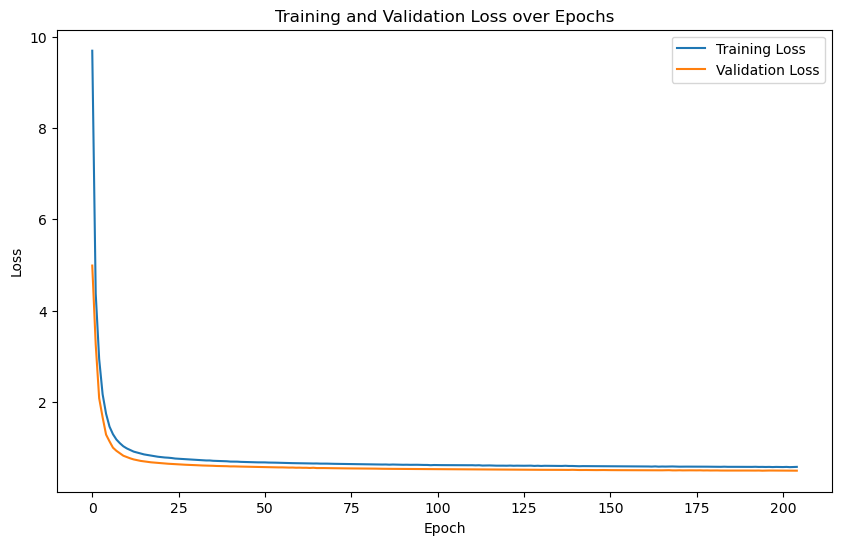

In [12]:
import matplotlib.pyplot as plt  # 导入 matplotlib.pyplot，而不是 matplotlib

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.savefig('../loss_curve_fig/GEX_human_neocortex_random_mask_finetune_full_loss_curve.png', dpi=400)  # 保存图像为png格式，400 dpi
plt.savefig('../loss_curve_fig/GEX_human_neocortex_random_mask_finetune_full_loss_curve.eps', format='eps', dpi=400)  # 保存图像为png格式，400 dpi

plt.show()


In [13]:
# 8. 使用 KNN 替代测试阶段的 FC 分类层
# 使用 encoder 提取训练集和测试集的 embedding
estim.model.eval()
with torch.no_grad():
    train_embeddings = estim.model.encoder(torch.tensor(X_train).float().to(device)).cpu().numpy()
    test_embeddings = estim.model.encoder(torch.tensor(X_test).float().to(device)).cpu().numpy()

In [14]:
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report

    

    # 初始化和训练KNN分类器
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(train_embeddings, y_train)
    
    # 模型预测
predictions = knn.predict(test_embeddings)

    # 计算准确率和 F1 分数
accuracy = accuracy_score(y_test, predictions)
print(f"KNN Accuracy on Test Data: {accuracy}")
f1 = f1_score(y_test, predictions, average='weighted')
print(f"Weighted F1 Score: {f1}")
    
macro_f1 = f1_score(y_test, predictions, average='macro')
print(f'Macro F1 Score: {macro_f1}')

    # 计算随机猜测的准确率
class_probabilities = np.bincount(y_test) / len(y_test)
random_accuracy = np.sum(class_probabilities ** 2)
print(f"Random Guess Accuracy: {random_accuracy}")

    # 生成分类报告
report = classification_report(y_test, predictions, target_names=label_encoder.classes_)
print(report)

KNN Accuracy on Test Data: 0.839885923813404
Weighted F1 Score: 0.8377352328184222
Macro F1 Score: 0.75425313205733
Random Guess Accuracy: 0.05800546520309893
                          precision    recall  f1-score   support

       Astrocyte-Fibrous       0.74      0.87      0.80       564
      Astrocyte-Immature       0.66      0.73      0.69       563
  Astrocyte-Protoplasmic       0.77      0.56      0.65       261
      Cajal-Retzius cell       0.81      0.33      0.47        64
          EN-IT-Immature       0.68      0.73      0.70      1316
              EN-L2_3-IT       0.84      0.86      0.85      1364
                EN-L4-IT       0.87      0.88      0.88      2540
                EN-L5-ET       0.83      0.51      0.63        86
                EN-L5-IT       0.88      0.88      0.88      1139
              EN-L5_6-NP       0.85      0.79      0.82       171
                EN-L6-CT       0.81      0.71      0.76       282
                EN-L6-IT       0.88      0.85   

In [15]:
with torch.no_grad():
    new_data_tensor = torch.tensor(new_data).float().to(device)
    SSL_embeddings = estim.model.encoder(new_data_tensor).detach().cpu().numpy()
SSL_embeddings

array([[  1.8047405 ,  -2.1106691 ,   2.1462905 , ...,  -0.1778791 ,
          5.705285  ,  -1.3255196 ],
       [  0.03252694,  -8.271882  ,   0.7562543 , ...,  -1.0260946 ,
          5.364297  ,  -2.3938942 ],
       [  3.544098  ,  -1.9000401 ,  -0.36229143, ...,  -2.251615  ,
          4.9453588 ,   1.3753891 ],
       ...,
       [ -2.3343039 ,  -1.1770703 ,  -4.4911056 , ...,   4.766422  ,
          6.001493  ,  -3.4985158 ],
       [-11.240284  , -17.503155  ,  -9.945245  , ...,  -5.907585  ,
         -2.1937757 ,   6.499844  ],
       [ -1.506301  ,  -1.5185106 ,  -0.3179501 , ...,   4.985946  ,
         10.120057  ,   0.68323374]], dtype=float32)

In [16]:
adata = sc.read_h5ad(data_dir)
adata.obsm['SSL_RM_FT'] = SSL_embeddings
adata.obsm['SSL_RM_FT']

array([[  1.8047405 ,  -2.1106691 ,   2.1462905 , ...,  -0.1778791 ,
          5.705285  ,  -1.3255196 ],
       [  0.03252694,  -8.271882  ,   0.7562543 , ...,  -1.0260946 ,
          5.364297  ,  -2.3938942 ],
       [  3.544098  ,  -1.9000401 ,  -0.36229143, ...,  -2.251615  ,
          4.9453588 ,   1.3753891 ],
       ...,
       [ -2.3343039 ,  -1.1770703 ,  -4.4911056 , ...,   4.766422  ,
          6.001493  ,  -3.4985158 ],
       [-11.240284  , -17.503155  ,  -9.945245  , ...,  -5.907585  ,
         -2.1937757 ,   6.499844  ],
       [ -1.506301  ,  -1.5185106 ,  -0.3179501 , ...,   4.985946  ,
         10.120057  ,   0.68323374]], dtype=float32)

In [17]:
adata.write_h5ad(data_dir)